## Chapter 4 [Spectroscopy](CH4_00-Spectroscopy.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Analyze Spectrum



part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.


## Load relevant python packages
### Check Installed Packages

In [ ]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2023.2.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

## First we import the essential libraries
All we need here should come with the annaconda or any other package

The xml library will enable us to read the Bruker file.

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt
import xml.etree.ElementTree as ET
import numpy as np
%gui qt

from scipy.ndimage import gaussian_filter

import numpy as np
import sys
sys.path.insert(0, '../../pyTEMlib/')

import warnings
warnings.filterwarnings('ignore')

## import the configuration files of pyTEMlib (we need access to the data folder)

%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.viz as plot
import pyTEMlib.file_tools as ft
import pyTEMlib.eds_tools as eds
from pyTEMlib.xrpa_x_sections import x_sections
import pyTEMlib.viz as plot


# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

## Select File

Please note that the above code cell has to be finished before you can open the * open file* dialog.

Test data are in the **SEM_example_data** folder, plese select EDS.rto file.

In [ ]:
datasets = ft.open_file()
chooser = ft.ChooseDataset(datasets)
v = plot.SpectrumView(datasets)

In [ ]:
dataset = chooser.dataset*0
for key in datasets:
    dataset += datasets[key]   
dataset.title = 'sum'
datasets['average'] = dataset/4
v2 = plot.SpectrumView(datasets)

In [4]:
sum_datasets = {'spectrum': dataset}

## Find Maximas

Of course we can find the maxima with the first derivative

In [8]:
from scipy.interpolate import InterpolatedUnivariateSpline
spectrum = dataset
energy_scale = dataset.get_spectrum_dims()
energy_scale = dataset.get_dimension_by_number(energy_scale[0])[0]
# Get a function that evaluates the linear spline at any x
f = InterpolatedUnivariateSpline(energy_scale,spectrum, k=1)

# Get a function that evaluates the derivative of the linear spline at any x
dfdx = f.derivative()

# Evaluate the derivative dydx at each x location...
dydx = dfdx(energy_scale)

from scipy.ndimage import gaussian_filter
derivative = gaussian_filter(dydx, sigma=3)
sum_datasets['derivative'] = dataset.like_data(derivative)
v3 = plot.SpectrumView(sum_datasets)

FigureWidget({
    'data': [{'marker': {'size': 2},
              'mode': 'lines+markers',
              'name…

## Peak Finding

We can also use the peak finding routine of the [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) to find all the maxima.


In [5]:
import scipy as sp 
import scipy.signal as sig


In [9]:

import plotly.graph_objects as go

start = np.searchsorted(energy_scale, 0.125)
## we use half the width of the resolution for smearing
width = int(np.ceil(125*1e-3/2 /(energy_scale[1]-energy_scale[0])/2)*2+1)
new_spectrum =  sp.signal.savgol_filter(spectrum[start:], width, 2) ## we use half the width of the resolution for smearing
new_energy_scale = energy_scale[start:]
major_peaks, _  = sp.signal.find_peaks(new_spectrum, prominence=1000)  
minor_peaks, _  = sp.signal.find_peaks(new_spectrum, prominence=100)  
peaks = major_peaks
peaks


v3.fig.add_trace(go.Scatter(x=new_energy_scale[minor_peaks], y=new_spectrum[minor_peaks], name='minor_peaks', mode="markers", 
                            marker=dict(size=10, color="MediumPurple")))
v3.fig.add_trace(go.Scatter(x=new_energy_scale[major_peaks], y=new_spectrum[major_peaks], name='major_peaks', mode="markers",
                            marker=dict(size=20, color="red")))


## Peak identification

Here we look up all the elemetns and see whether the position of major line (K-L3, K-L2' or 'L3-M5') coincides with a peak position as found above.

Then we plot all the lines of such an element with the appropriate weight.

The positions and the weight are tabulated in the **ffast.pkl** file introduced in the [Characteristic X-Ray peaks](CH4-Characteristic_X_Rays.ipynb#X-ray-Weight-of-Lines) notebook

found_element 29 929.5 935.0
found_element 36 1586.0 1590.0
found_element 38 1806.5 1810.0
found_element 76 8910.800000000001 8905.0
C K-L2 280.0
O K-L3 525.0
Cu L3-M5 935.0
Kr L3-M5 1590.0
Sr L3-M5 1810.0
Ti K-L3 4505.0
Cu K-L3 8045.0
Os L3-M5 8905.0


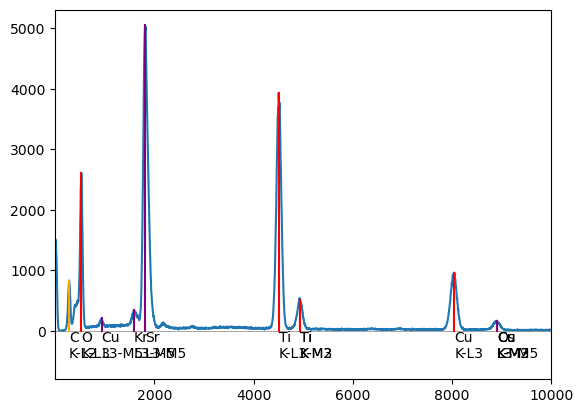

In [10]:
import pickle 
pkl_file = open('data/ffast.pkl', 'rb')
ffast = pickle.load(pkl_file)
pkl_file.close()

plt.figure()
#plt.plot(energy_scale1,spectrum2, label = 'spectrum 1')
#plt.plot(energy_scale1,gaussian_filter(spectrum1, sigma=1), label = 'filtered spectrum 1')
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.xlim(0.1,10000)
plt.ylim(-800)
plt.gca().axhline(y=0,color='gray',  linewidth = 0.5);

out_tags = {}
out_tags['spectra'] = {}

out_tags['spectra'][0] = {}
out_tags['spectra'][0]['data'] = spectrum
out_tags['spectra'][0]['energy_scale'] = energy_scale
out_tags['spectra'][0]['energy_scale_start'] = start
out_tags['spectra'][0]['smooth_spectrum'] = new_spectrum
out_tags['spectra'][0]['smooth_energy_scale'] = new_energy_scale

out_tags['spectra'][0]['elements'] ={}


#print(ffast[6])
number_of_elements = 0
for peak in minor_peaks:
    for element in range(1,93):
        if 'K-L3' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L3']['position']- new_energy_scale[peak]) <10:
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L3'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]
                number_of_elements += 1
                plt.plot([ffast[element]['lines']['K-L3']['position'],ffast[element]['lines']['K-L3']['position']], [0,new_spectrum[peak]], color = 'red')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L3', verticalalignment='top')
                for line in ffast[element]['lines']:
                    if 'K' in line:
                        if abs(ffast[element]['lines'][line]['position']-ffast[element]['lines']['K-L3']['position'])> 20:
                            if ffast[element]['lines'][line]['weight']>0.07:
                                #print(element, ffast[element]['lines'][line],new_spectrum[peak]*ffast[element]['lines'][line]['weight'])
                                plt.plot([ffast[element]['lines'][line]['position'],ffast[element]['lines'][line]['position']], [0,new_spectrum[peak]*ffast[element]['lines'][line]['weight']], color = 'red')
                                plt.text(ffast[element]['lines'][line]['position'],0, ffast[element]['element']+'\n'+line, verticalalignment='top')
                            
        elif 'K-L2' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L2']['position']- new_energy_scale[peak]) <10:
                plt.plot([new_energy_scale[peak],new_energy_scale[peak]], [0,new_spectrum[peak]], color = 'orange')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L2', verticalalignment='top')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L2'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]
                
                number_of_elements += 1
        if 'L3-M5' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['L3-M5']['position']- new_energy_scale[peak]) <10:
                pass
                print('found_element', element,ffast[element]['lines']['L3-M5']['position'], new_energy_scale[peak] )
                plt.plot([new_energy_scale[peak],new_energy_scale[peak]], [0,new_spectrum[peak]], color = 'purple')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nL3-M5', verticalalignment='top')
                
                #plt.scatter( new_energy_scale[peak], new_spectrum[peak], color = 'blue')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'L3-M5'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]
                
                number_of_elements += 1
for element in out_tags['spectra'][0]['elements']:                
    print(out_tags['spectra'][0]['elements'][element]['element'],out_tags['spectra'][0]['elements'][element]['found_lines'], out_tags['spectra'][0]['elements'][element]['experimental_peak_energy'])
    

In [12]:
for element in out_tags['spectra'][0]['elements']:                
    print(out_tags['spectra'][0]['elements'][element]['element'],out_tags['spectra'][0]['elements'][element]['found_lines'], out_tags['spectra'][0]['elements'][element]['experimental_peak_energy'])

C K-L2 280.0
O K-L3 525.0
Cu L3-M5 935.0
Kr L3-M5 1590.0
Sr L3-M5 1810.0
Ti K-L3 4505.0
Cu K-L3 8045.0
Os L3-M5 8905.0


In [ ]:
print(out_tags['spectra'][0]['elements'][0])#['K-L2']['weight'] = 0.5
#del out_tags['spectra'][0]['elements'][7]
for ele in out_tags['spectra'][0]['elements']:
    print(ele, out_tags['spectra'][0]['elements'][ele]['element'])

del  out_tags['spectra'][0]['elements'][6]

## Plotting Gaussians in the Peaks

Please note the different width (FWHM). Here I guessed the peak width for two peaks.

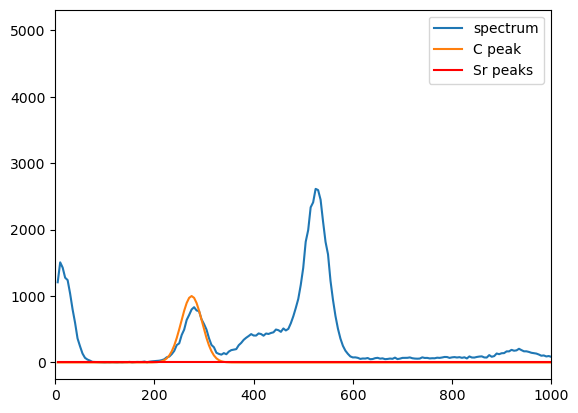

In [17]:
def gaussian(enrgy_scale, mu, FWHM):
    sig = FWHM/2/np.sqrt(2*np.log(2))
    return np.exp(-np.power(enrgy_scale - mu, 2.) / (2 * np.power(sig, 2.)))

C_peak = gaussian(new_energy_scale, 275, 50)
Sr_peak = gaussian(new_energy_scale, 1810.0, 120)
plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'spectrum')
plt.plot(new_energy_scale,C_peak*1000, label = 'C peak')
plt.plot(new_energy_scale,Sr_peak*5000, label = 'Sr peaks', color = 'red')
plt.xlim(.0,1000)
plt.legend()

## Origin of Line Width

Electron hole pairs are created with a standard deviation corresponding to the quantum mechanical shot-noise (Poisson statistic).
The distribution is then a Gaussian with the width of the standard deviation $\sigma$.

For the Mn K-L2,3 peak< this width would be 40 electron hole pairs.
The full width at half maximum (FWHM) of the Mn K-L2,3 edge would then be (FWHM of Gaussian  is 2.35 * 𝜎) about 106 eV a major component of the observed resolution of 125 eV  in good EDS systems.


##  Line Width Estimate
Fiori and Newbury 1978
From a reference peak at $E_{ref}$  and the measured FWHM of the peak $FWHM_{ref}$ in eV, we can estimate the peak width of the other peaks

$$ FWHM =  \sqrt{2.5 \times (E-E_{ref}) + FWHM_{ref}^2 }$$ 

Gernerally we use the Mn K-L2,3 peak $E_{ref}$ = 5895 eV as a reference. In our spectrometer we got for the setup above: $FWHM_{ref} = 136$ eV

In [21]:
E_ref = 5895.0
FWHM_ref = 128 #eV
E= 275 
def getFWHM(E):
    return np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)


print(f'C should have a line width of {getFWHM(E):.2f} eV')

C should have a line width of 48.31 eV


Using that we get for all peaks in the low energy region:

In [ ]:
def getPeak(E, energy_scale):
    E_ref = 5895.0
    FWHM_ref = 136 #eV
    FWHM  = np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)
    return gaussian(energy_scale, E, FWHM)
    
E= 275 
C_peak = getPeak(E,new_energy_scale)
E = 1810
Sr_peak = getPeak(E,new_energy_scale)
E = 4505
Ti_peak = getPeak(E,new_energy_scale)
E = 528
O_peak = getPeak(E,new_energy_scale)
plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,C_peak*1033, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,Sr_peak*5500, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,Ti_peak*4300, label = 'filtered spectrum 1')

plt.plot(new_energy_scale,O_peak*2700, label = 'filtered spectrum 1')
plt.xlim(1,1000)

## Detector Efficiency

In [ ]:
from scipy.interpolate import interp1d
import scipy.constants as const


## layer thicknesses of commen materials in EDS detectors in m
nickelLayer = 0.* 1e-9 # in m
alLayer = 30 *1e-9    # in m
C_window = 2 *1e-6    # in m
goldLayer = 0.* 1e-9   # in m
deadLayer = 100 *1e-9  # in m
detector_thickness = 45 * 1e-3  # in m

area = 30 * 1e-6 #in m2
oo4pi = 1.0 / (4.0 * np.pi)

#We make a linear energy scale 
energy_scale = np.linspace(.1,60,2000)

## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[14]['E']/1000.,ffast[14]['photoabsorption'],kind='linear') 
mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m

## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[13]['E']/1000.,ffast[13]['photoabsorption'],kind='linear') 
mu_Al = lin(energy_scale) * ffast[13]['nominal_density'] *100. #1/cm -> 1/m

lin = interp1d(ffast[6]['E']/1000.,ffast[6]['photoabsorption'],kind='linear') 
mu_C = lin(energy_scale) * ffast[6]['nominal_density'] *100. #1/cm -> 1/m
 
detector_Efficiency1 = np.exp(-mu_C * C_window) * np.exp(-mu_Al * alLayer)* np.exp(-mu_Si * deadLayer) 
detector_Efficiency2 = (1.0 - np.exp(-mu_Si * detector_thickness))# * oo4pi;
detector_Efficiency =detector_Efficiency1 * detector_Efficiency2#* oo4pi;

plt.figure()
plt.plot(energy_scale, detector_Efficiency*100, label = 'total absorption')
plt.plot(energy_scale, detector_Efficiency1*100, label = 'detector absorption')
plt.plot(energy_scale, detector_Efficiency2*100, label= 'detector efficiency')
plt.gca().set_xlabel('energy [keV]');
plt.gca().set_ylabel('efficiency [%]') 
plt.legend();
energy_scale = new_energy_scale

## Detector Parameters from file

In [ ]:
tags = {'detector': {'window':{'contacts': {'Z': 13, 'thickness': 30*1e-3}},
                    'SiDeadLayerThickness': .1,
                    'DetectorThickness': .45
                    }}
print(tags['detector']['window'])
print(tags['detector'].keys())
print(f"{float(tags['detector']['SiDeadLayerThickness'])*1e-6:.3g}")
print(f"{float(tags['detector']['DetectorThickness'])/10:.3f}")
for key in tags['detector']['window']:
    print(f"{tags['detector']['window'][key]['Z']}, {tags['detector']['window'][key]['thickness']*1e-6:.2g}")

## Comparison to generic efficiency

In [ ]:
from scipy.interpolate import interp1d
import scipy.constants as const

def detector_efficiency(tags, energy_scale):
    detector_Efficiency1 = np.ones(len(energy_scale))
    for key in tags['detector']['window']:
        Z = int(tags['detector']['window'][key]['Z'])
        if Z < 14:
            t = tags['detector']['window'][key]['thickness']

            ## interpolate mass absorption coefficient to our energy scale
            lin = interp1d(ffast[Z]['E'],ffast[Z]['photoabsorption'],kind='linear') 
            mu = lin(energy_scale) * ffast[Z]['nominal_density']*100. #1/cm -> 1/m
            detector_Efficiency1 = detector_Efficiency1 * np.exp(-mu * t)
            print(Z,t)
        
    t = float(tags['detector']['SiDeadLayerThickness'])*1e-6
    print(t)
    t = .30*1e-7
    print(t)
    lin = interp1d(ffast[14]['E'],ffast[14]['photoabsorption'],kind='linear') 
    mu = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m
    detector_Efficiency1 = detector_Efficiency1 * np.exp(-mu * t)
    detector_thickness = float(tags['detector']['DetectorThickness'])*1e-1
    ## interpolate mass absorption coefficient to our energy scale
    mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m
    print(detector_thickness)
    
    detector_Efficiency2 = (1.0 - np.exp(-mu * detector_thickness))# * oo4pi;

    
    return detector_Efficiency1*detector_Efficiency2



de = detector_efficiency(tags, energy_scale[1:])    
## layer thicknesses of commen materials in EDS detectors in m
nickelLayer = 0.* 1e-9 # in m
alLayer = 30 *1e-9    # in m
C_window = 2 *1e-6    # in m
goldLayer = 0.* 1e-9   # in m
deadLayer = 100 *1e-9  # in m
detector_thickness = 45 * 1e-3  # in m
print(detector_thickness)
area = 30 * 1e-6 #in m2
oo4pi = 1.0 / (4.0 * np.pi)

#We make a linear energy scale 
energy_scale = new_energy_scale[1:]


## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[14]['E'],ffast[14]['photoabsorption'],kind='linear') 
mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m

## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[13]['E'],ffast[13]['photoabsorption'],kind='linear') 
mu_Al = lin(energy_scale) * ffast[13]['nominal_density'] *100. #1/cm -> 1/m

lin = interp1d(ffast[6]['E'],ffast[6]['photoabsorption'],kind='linear') 
mu_C = lin(energy_scale) * ffast[6]['nominal_density'] *100. #1/cm -> 1/m
 
detector_Efficiency1 = np.exp(-mu_C * C_window) * np.exp(-mu_Al * alLayer)#* np.exp(-mu_Si * deadLayer) 
detector_Efficiency2 = (1.0 - np.exp(-mu_Si * detector_thickness))# * oo4pi;
detector_Efficiency =detector_Efficiency1 * detector_Efficiency2#* oo4pi;

plt.figure()
plt.plot(energy_scale, detector_Efficiency , label = 'generic')
plt.plot(energy_scale[1:], de, label = 'UTK detector')
#plt.plot(energy_scale*1000, de* np.exp(-mu_Si * deadLayer) )
#plt.plot(energy_scale*1000, de* np.exp(-mu_Si * deadLayer) * detector_Efficiency2 )
plt.legend();
plt.xlim(0,9000);


In [ ]:
mu_Si

## Plotting background and lines 

In [ ]:
Peaks = []
elements_peaks = []
intensities = []
for element in out_tags['spectra'][0]['elements']:
    el_dict = out_tags['spectra'][0]['elements'][element]
    
    position = el_dict['lines'][el_dict['found_lines']]['position']
    weight = 0
    for line in el_dict['lines']:
        if abs(position - el_dict['lines'][line]['position'])<20:
            weight += el_dict['lines'][line]['weight']
    index = np.searchsorted(new_energy_scale,el_dict['lines'][el_dict['found_lines']]['position']/1000.)  
    intensity = new_spectrum[index]/weight
    added_peaks = np.zeros(len(new_energy_scale))
    for line in el_dict['lines']: 
        if line[0] == el_dict['found_lines'][0]:
            if el_dict['lines'][line]['weight']> 0.01:
                p = getPeak(el_dict['lines'][line]['position']/1000.,new_energy_scale)*el_dict['lines'][line]['weight']
                Peaks.append(p)
                added_peaks = added_peaks + p 
    elements_peaks.append(added_peaks)        
    intensities.append(intensity)
    
plt.figure()
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
#plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
for i in range(len(elements_peaks)):
    plt.plot(new_energy_scale,elements_peaks[i]*intensities[i], label = f'Peak{i}')
    pass
peaks = np.array(Peaks)
plt.plot(new_energy_scale,peaks.sum(axis=0), label = f'Peaks', color = 'blue')
print(peaks.shape)
#plt.xlim(0,5)    
offset = float(tags[0]['spectrum_header']['CalibAbs'])
scale  = float(tags[0]['spectrum_header']['CalibLin'])
energy_scale1 = np.arange(len(spectrum1))*scale+offset
p = [1, 37, .3, offset, scale]
E_0= 20
E = new_energy_scale
N = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
N = de * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)

pp = p[0:5].copy()
for i in range(len(elements_peaks)):
    pp.append(intensities[i])

plt.plot(new_energy_scale,N, color= 'orange')

plt.xlim(0,4)

detector_Efficiency = de

In [ ]:
detector_Efficiency.shape

## As a function

In [ ]:
def model(p,energy_scale):
    E = energy_scale
    
    spectrum = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
    
    for i in range(5,len(p)):
        spectrum = spectrum+elements_peaks[i-5]*abs(p[i])
    return spectrum
spectrum3 = model(pp[:-1],new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.xlim(0,4)

## Fitting above function to spectrum

In [ ]:

from scipy.optimize import leastsq 

## background fitting 
def specfit(p, y, x):
    err = y - model(p,x)
    return err

p, lsq = leastsq(specfit, pp[:-1], args=(new_spectrum, new_energy_scale), maxfev=2000)


In [ ]:
print( f'element\t end   \t   start ')
for i, element in enumerate(out_tags['spectra'][0]['elements']):
    if i<len(p)-5:
        el_dict = out_tags['spectra'][0]['elements'][element]
        print(f"{el_dict['element']:2s}: \t  {abs(p[i+5]):6.2f} \t  {pp[i+5]:.2f}")
#print(p,pp)

In [ ]:
spectrum3 = model(p,new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.plot(new_energy_scale, new_spectrum-spectrum3)
plt.gca().axhline(y=0,color='gray');

plt.xlim(0,4);

## Energy Scale

What happened?


## Detector Artifacts

### Si Escape peak
The 1s state of a Si atom in the detector crystal is excited but then instead of being further detected by absoption a A!!uger electron leaves the crystal. The electron hole pairs of this event are missing and a lower energy is recorded. 

![Si-Escape](./images/escape-peak2.jpg)

### Detector Silicon Peak
Internal fluorescence peak

![Si-Detector](./images/DetectorSilicon4.jpg)

### Sum Peak
Two photons are detected at the same time.
This signal is suppressed by most acquistion systems, but a few are still slipping through.
A peak apears at the energy of the sum of two strong peaks.

# Composition
Following 

[D.E. Newbury, C.R. Swyt, and R.L. Myklebust,
“Standardless” Quantitative Electron Probe
Microanalysis with Energy-Dispersive X-ray
Spectrometry: Is It Worth the Risk?, Anal. Chem. 1995, 67, 1866-1871](https://doi-org.proxy.lib.utk.edu/10.1021/ac00107a017)

to calculate the mass concentration $C_i$ from the intensity of a line ($I_{ch}$), we use:

$$ I_{ch} = \epsilon  (\omega N_A \rho C_i / A) R \int _{E_c}^{E_0} \frac{Q_i}{dE/ds}dE $$


- $\omega$ : fluorescence yield    
- $N_A$: Avogadro’s number          
- $\rho$: density                       
- $C_i$: mass concentration of element $i$  
- $A$:atomic weight           
- $R$: backscatter loss
- $Q_i$: ionization cross sectiond
- $E/ds$: rate of energy loss 
- $E_0$: incident beam energy  
- $E_c$: excitation energy
- $\epsilon$: EDS efficiency

where: $N_A * \rho * C_i/A$: volume density of element $i$ (atoms per unit volume)  

What do we know at this point?

$\omega; N_A; \rho; A; Q_i; E_0; E_c; and \epsilon$

In [ ]:
def BrowningEmpiricalCrossSection(elm , energy):
    """ * Computes the elastic scattering cross section for electrons of energy between
     * 0.1 and 30 keV for the specified element target. The algorithm comes from<br>
     * Browning R, Li TZ, Chui B, Ye J, Pease FW, Czyzewski Z &amp; Joy D; J Appl
     * Phys 76 (4) 15-Aug-1994 2016-2022

     * The implementation is designed to be similar to the implementation found in
     * MONSEL.
     * Copyright: Pursuant to title 17 Section 105 of the United States Code this
     * software is not subject to copyright protection and is in the public domain
     * Company: National Institute of Standards and Technology
     * @author Nicholas W. M. Ritchie
     * @version 1.0

     */
     Modified by Gerd Duscher, UTK
    """

    #/**
    #* totalCrossSection - Computes the total cross section for an electron of
    #* the specified energy.
    #* 
    # @param energy double - In keV
    # @return double - in square meters
    #*/
    e = energy  #in keV
    re = np.sqrt(e);
    return (3.0e-22 * elm**1.7) / (e + (0.005 * elm**1.7 * re) + ((0.0007 * elm**2) / re));
   

In [ ]:
print(BrowningEmpiricalCrossSection(6,277)*1e18, r'nm^2')

## Back: [Detector Response](CH4_15-Detector.ipynb)
## Next: [Quantify_Spectrum](CH4_17-Quantify_EDS_Spectrum.ipynb)
## List of Content: [Front](../_MSE672_Intro_TEM.ipynb)